In [ ]:
!pip install -U gdown


In [ ]:
import gdown

# File ID from the shared link
file_id = "1K3FLyL5GqHWINDdi2GMmpur7CVYdbtje"
# Destination filename
output = "drone_payload_dataset.zip"

# Construct the direct download URL and download
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1K3FLyL5GqHWINDdi2GMmpur7CVYdbtje
From (redirected): https://drive.google.com/uc?id=1K3FLyL5GqHWINDdi2GMmpur7CVYdbtje&confirm=t&uuid=32a8ee22-1812-4d22-b7ea-b2d89312fbb5
To: /content/drone_payload_dataset.zip
100%|██████████| 4.08G/4.08G [00:47<00:00, 86.0MB/s]


'drone_payload_dataset.zip'

In [ ]:
import zipfile

with zipfile.ZipFile("drone_payload_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("drone_dataset")


In [ ]:
from pathlib import Path
import pandas as pd

# Define base paths
base_dir = Path("drone_dataset/payload")

rgb_img_dir = base_dir / "RGB/images"
rgb_label_dir = base_dir / "RGB/labels"
ir_img_dir = base_dir / "IR/images"
ir_label_dir = base_dir / "IR/labels"

data = []

# Loop through RGB images
for rgb_path in rgb_img_dir.glob("*.jpg"):
    base_name = rgb_path.stem  # without .jpg
    label_path = rgb_label_dir / f"{base_name}.txt"

    if label_path.exists():
        data.append({
            "image_type": "RGB",
            "image_path": rgb_path,
            "label_path": label_path,
            "base_id": base_name.split('_')[0]  # e.g., "199"
        })

# Loop through IR images
for ir_path in ir_img_dir.glob("*.jpg"):
    base_name = ir_path.stem
    label_path = ir_label_dir / f"{base_name}.txt"

    if label_path.exists():
        data.append({
            "image_type": "IR",
            "image_path": ir_path,
            "label_path": label_path,
            "base_id": base_name.split('_')[0]
        })

df = pd.DataFrame(data)
df.head()


,image_type,image_path,label_path,base_id
0,RGB,drone_dataset/payload/RGB/images/156_png.rf.3b...,drone_dataset/payload/RGB/labels/156_png.rf.3b...,156
1,RGB,drone_dataset/payload/RGB/images/81_png.rf.2b3...,drone_dataset/payload/RGB/labels/81_png.rf.2b3...,81
2,RGB,drone_dataset/payload/RGB/images/41_png.rf.cf4...,drone_dataset/payload/RGB/labels/41_png.rf.cf4...,41
3,RGB,drone_dataset/payload/RGB/images/14_png.rf.53f...,drone_dataset/payload/RGB/labels/14_png.rf.53f...,14
4,RGB,drone_dataset/payload/RGB/images/182_png.rf.cb...,drone_dataset/payload/RGB/labels/182_png.rf.cb...,182


In [ ]:
from pathlib import Path
import pandas as pd
from collections import defaultdict

# Base paths
base_dir = Path("drone_dataset/payload")
rgb_img_dir = base_dir / "RGB/images"
rgb_label_dir = base_dir / "RGB/labels"

# Group image paths by prefix before "_"
grouped_images = defaultdict(list)

for rgb_path in rgb_img_dir.glob("*.jpg"):
    base_name = rgb_path.stem  # e.g., '1_png.rf.xxxxx'
    prefix = base_name.split('_')[0]  # e.g., '1'
    grouped_images[prefix].append(rgb_path)

# Helper to extract payload class
def get_payload_quality(label_path):
    try:
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            if line:
                cls = int(line.split()[0])
                return "good" if cls == 1 else "bad"
    except:
        return "unknown"

# Select 5 images from each group
selected_data = []

for prefix, img_paths in grouped_images.items():
    selected_images = img_paths[:5]  # pick first 5 (or random.sample for randomness)

    for img_path in selected_images:
        label_path = rgb_label_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            payload_quality = get_payload_quality(label_path)
            selected_data.append({
                "base_id": prefix,
                "image_path": str(img_path),
                "label_path": str(label_path),
                "payload_quality": payload_quality
            })

# Create final DataFrame
df_selected = pd.DataFrame(selected_data)

# Optional: save to CSV
df_selected.to_csv("selected_payload_training_data.csv", index=False)

# Preview
print(df_selected.head())


  base_id                                         image_path  \
0     156  drone_dataset/payload/RGB/images/156_png.rf.3b...   
1     156  drone_dataset/payload/RGB/images/156_png.rf.3b...   
2     156  drone_dataset/payload/RGB/images/156_png.rf.38...   
3     156  drone_dataset/payload/RGB/images/156_png.rf.db...   
4     156  drone_dataset/payload/RGB/images/156_png.rf.3b...   

                                          label_path payload_quality  
0  drone_dataset/payload/RGB/labels/156_png.rf.3b...             bad  
1  drone_dataset/payload/RGB/labels/156_png.rf.3b...             bad  
2  drone_dataset/payload/RGB/labels/156_png.rf.38...             bad  
3  drone_dataset/payload/RGB/labels/156_png.rf.db...             bad  
4  drone_dataset/payload/RGB/labels/156_png.rf.3b...             bad  


In [ ]:
import pandas as pd
from pathlib import Path
import shutil

# Load your CSV
df = pd.read_csv("selected_payload_training_data.csv")

# Output folders
image_out_dir = Path("yolodataset/images")
label_out_dir = Path("yolodataset/labels")

# Create output directories
image_out_dir.mkdir(parents=True, exist_ok=True)
label_out_dir.mkdir(parents=True, exist_ok=True)

# Loop and copy
for image_path in df["image_path"]:
    image_path = Path(image_path)
    label_path = Path(str(image_path).replace("/images/", "/labels/")).with_suffix(".txt")

    if image_path.exists() and label_path.exists():
        shutil.copy(image_path, image_out_dir / image_path.name)
        shutil.copy(label_path, label_out_dir / label_path.name)
    else:
        print(f"Missing: {image_path} or {label_path}")


In [ ]:
import os

image_dir = "/content/yolodataset/images"
num_images = len([f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))])
print("Number of images:", num_images)


Number of images: 1057


In [ ]:
!pip install -U ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
from pathlib import Path
import pandas as pd

image_dir = Path("yolodataset/images")
label_dir = Path("yolodataset/labels")

records = []

for img_path in image_dir.glob("*.jpg"):
    label_path = label_dir / img_path.with_suffix(".txt").name

    if not label_path.exists():
        continue  # skip if label missing

    with open(label_path) as f:
        content = f.readlines()
        classes = [int(line.split()[0]) for line in content]

    label = 1 if 1 in classes else 0  # good if at least one '1', else bad

    records.append({
        "image_path": str(img_path),
        "label": label
    })

df = pd.DataFrame(records)
df["label_name"] = df["label"].map({0: "bad", 1: "good"})
df.head()


,image_path,label,label_name
0,yolodataset/images/156_png.rf.3b6c90fbe91960aa...,0,bad
1,yolodataset/images/81_png.rf.2b3361cf218a01388...,1,good
2,yolodataset/images/41_png.rf.cf47766575b1f0d22...,0,bad
3,yolodataset/images/14_png.rf.53f77262b4f22ea4f...,0,bad
4,yolodataset/images/182_png.rf.cb54922023601647...,0,bad


In [ ]:
from sklearn.model_selection import train_test_split
import shutil

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

for split_name, split_df in [("train", train_df), ("val", val_df)]:
    for _, row in split_df.iterrows():
        class_dir = Path(f"drone_cls_dataset/{split_name}/{row['label_name']}")
        class_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(row["image_path"], class_dir / Path(row["image_path"]).name)


In [ ]:
from ultralytics import YOLO

# Load classification model
model = YOLO("yolov8s-cls.pt")  # Use 'n', 's', 'm', or 'l' depending on size/speed tradeoff

# Train the classifier
model.train(data="drone_cls_dataset", epochs=20, imgsz=224)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 12.3M/12.3M [00:00<00:00, 362MB/s]


Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=drone_cls_dataset, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

train: Scanning /content/drone_cls_dataset/train... 845 images, 0 corrupt: 100%|██████████| 845/845 [00:00<00:00, 3549.91it/s]

train: New cache created: /content/drone_cls_dataset/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 973.6±400.0 MB/s, size: 42.4 KB)



val: Scanning /content/drone_cls_dataset/val... 212 images, 0 corrupt: 100%|██████████| 212/212 [00:00<00:00, 6284.80it/s]

val: New cache created: /content/drone_cls_dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/20         0G     0.6376         16        224:   2%|▏         | 1/53 [00:04<03:30,  4.05s/it]


100%|██████████| 755k/755k [00:00<00:00, 58.4MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]

                   all      0.972          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20         0G    0.06818         13        224: 100%|██████████| 53/53 [02:05<00:00,  2.37s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20         0G    0.03596         13        224: 100%|██████████| 53/53 [02:03<00:00,  2.32s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20         0G    0.06795         13        224: 100%|██████████| 53/53 [02:02<00:00,  2.32s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20         0G    0.04145         13        224: 100%|██████████| 53/53 [02:04<00:00,  2.36s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20         0G     0.0342         13        224: 100%|██████████| 53/53 [02:05<00:00,  2.37s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]

                   all      0.986          1

      Epoch    GPU_mem       loss  Instances       Size



      15/20         0G    0.02817         13        224: 100%|██████████| 53/53 [02:04<00:00,  2.34s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all      0.986          1

      Epoch    GPU_mem       loss  Instances       Size



      16/20         0G    0.02965         13        224: 100%|██████████| 53/53 [02:04<00:00,  2.34s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20         0G    0.04279         13        224: 100%|██████████| 53/53 [02:04<00:00,  2.35s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20         0G    0.01719         13        224: 100%|██████████| 53/53 [02:04<00:00,  2.35s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20         0G    0.02065         13        224: 100%|██████████| 53/53 [02:04<00:00,  2.35s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20         0G    0.02561         13        224: 100%|██████████| 53/53 [02:04<00:00,  2.35s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]

                   all          1          1



20 epochs completed in 0.763 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train/weights/best.pt, 10.3MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8s-cls summary (fused): 30 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: /content/drone_cls_dataset/train... found 845 images in 2 classes ✅ 
val: /content/drone_cls_dataset/val... found 212 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


                   all          1          1
Speed: 0.0ms preprocess, 43.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aad2228b3d0>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.0006447028334082032, 'inference': 42.96735752830217, 'loss': 4.3499996862456614e-05, 'postprocess': 0.00011794339519288974}
task: 'classify'
top1: 1.0
top5: 1.0

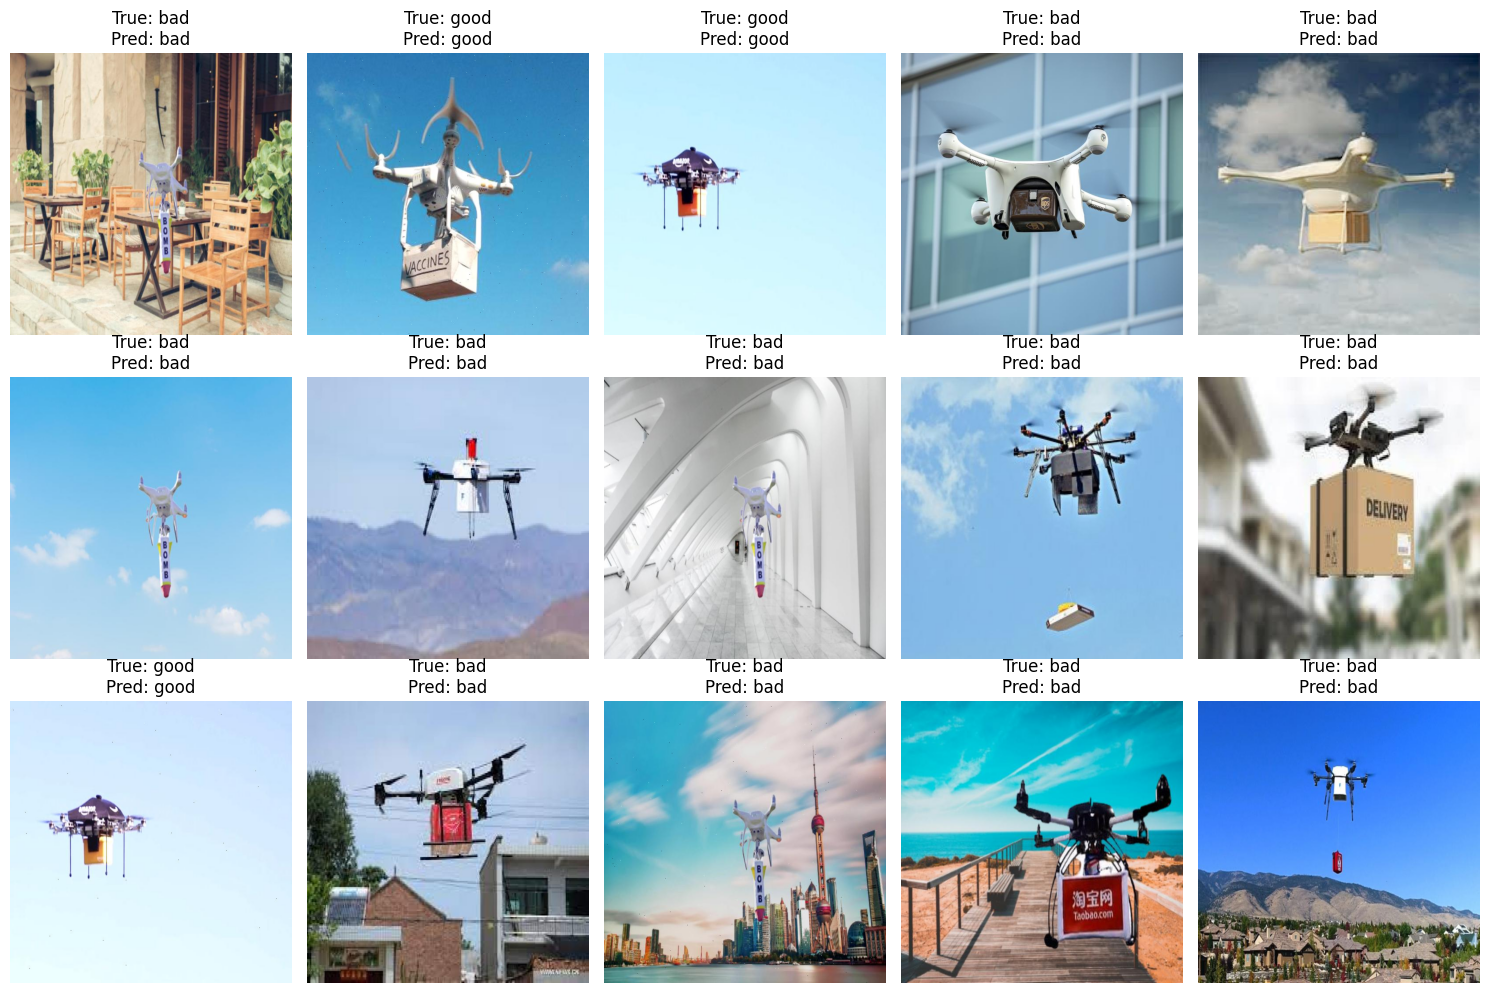

In [ ]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load your trained classification model
model = YOLO("runs/classify/train/weights/best.pt")  # Change path if needed

# Define validation directory
val_dir = Path("drone_cls_dataset/val")

# Gather all images and true labels
val_images = []
for class_name in ["good", "bad"]:
    class_path = val_dir / class_name
    for img_path in class_path.glob("*.jpg"):
        val_images.append({
            "image_path": img_path,
            "true_label": class_name
        })

# Pick 15 random samples
sample_images = random.sample(val_images, 15)

# Plot results
plt.figure(figsize=(15, 10))

for idx, item in enumerate(sample_images):
    image_path = item["image_path"]
    true_label = item["true_label"]

    # Run inference
    results = model(str(image_path), verbose=False)
    pred_idx = results[0].probs.top1
    pred_label = results[0].names[pred_idx]

    # Plot
    image = Image.open(image_path)
    plt.subplot(3, 5, idx + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
